# Decision Trees

In machine learning, decision trees are supervised learning algorithms used for both classification and regression tasks. They represent data-driven decisions through a tree-like structure, where internal nodes test specific features, branches represent outcomes of these tests, and leaf nodes provide final predictions. Decision trees are intuitive and easy to visualise because they are white box models. They can handle both categorical and numerical data with minimal preprocessing. Despite their simplicity and interpretability, they are prone to overfitting, especially with deep trees. To address this, ensemble methods such as random forests and gradient boosting are commonly employed to improve generalization and performance. In this notebook, we will dicuss the theoretical underpinnings of decision trees and provide a Python implementation. 

In [ ]:
# Importing,
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Loading dataset,
iris_dataset = datasets.load_iris()

Let us consider the Iris dataset, 

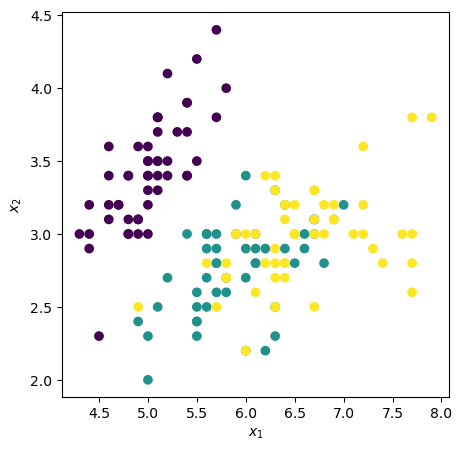

In [80]:
# Extracting features,
X1 = iris_dataset["data"].T[0]
X2 = iris_dataset["data"].T[1]
X = np.array([X1, X2]).T
y = iris_dataset["target"]

# Plotting,
fig, axis = plt.subplots(1, 1, figsize=(5, 5))
axis.scatter(X1, X2, c=y)
axis.set_xlabel("$x_1$")
axis.set_ylabel("$x_2$")
plt.show()

In [81]:
def compute_entropy(y):
    """Helper function which computes the Shannon entropy of a given node."""

    # Computing probabilities Pj,
    classes, classes_counts = np.unique(y, return_counts=True)
    classes_probs = classes_counts/len(y)

    # Computing the Shannon entropy of the node,
    entropy = -np.sum(classes_probs*np.log2(classes_probs))

    return entropy

def split(X, y):
    """Binary splits a parent node into two child nodes based on the decision that maximises information gain in accordance
    with Shannon entropy."""

    # Placeholder variables,
    max_gain = -1
    split_threshold_value = None
    X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = None, None, None, None

    # Computing entropy before split,
    S_parent = compute_entropy(y)

    # Determining best split,
    features_thresholds = np.unique(X.T, axis=-1)

    # Double loop, first for each feature, second for each threshold value,
    for feature_idx, thresholds in enumerate(features_thresholds):

        # Extracting feature values,
        X_feature = X.T[feature_idx]

        for threshold_value in thresholds:

            # Splitting data in parent node into child nodes,
            left_split_idxs, right_split_idxs = np.where(X_feature <= threshold_value)[0], np.where(X_feature > threshold_value)[0]
            X_left_split, X_right_split = X[left_split_idxs], X[right_split_idxs]
            y_left_split, y_right_split = y[left_split_idxs], y[right_split_idxs]

            # Compute entropy after split,
            S_left, S_right = compute_entropy(y_left_split), compute_entropy(y_right_split)

            # Calculating information gain,
            w1, w2 = len(y_left_split)/len(y), len(y_right_split)/len(y)
            delta_S = S_parent - (w1*S_left + w2*S_right)
            
            # Tracking maximum information gain,
            if delta_S > max_gain:
                
                # Updating nodes associated with the best split,
                max_gain, split_threshold_value, split_feature = delta_S, threshold_value, feature_idx
                X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = X_left_split, X_right_split, y_left_split, y_right_split

    return X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split, (split_feature, split_threshold_value)


In [4]:
X_left_split, X_right_split, y_left_split, y_right_split, decision = split(X, y)
decision

(1, 1.9)

In [5]:
X_left_split, X__right_split, y_left_split, y_right_split, decision = split(X_right_split, y_right_split)
decision

(1, 4.7)

Let us create the DecisionTreeClassifier class,

In [82]:
class DecisionTreeClassifier():

    def __init__(self, max_depth):
        """Constructor method for the DecisionTreeClassifier class. We simply create the class variables."""
        
        # Class variables for the data and nodes,
        self.X, self.y, self.nodes, self.leaves = None, None, None, None

        # Stopping criteria,
        self.max_depth = max_depth

        return None
    
    def fit(self, X, y):
        self.X, self.y = X, y

        # Creating the root node,
        root_node = Node(self.X, self.y, parent_node=None)
        self.nodes, self.leaves = [root_node], [root_node]

        # Growth algorithm,
        for i in range(self.max_depth):
            new_leaves = self.grow_tree()

            # Adding child nodes,
            self.nodes.extend(new_leaves)

        # Assigning class predictions to leaves (terminate node) based on majority vote,
        for leaf_node in self.leaves:
            leaf_node.class_prediction = np.bincount(leaf_node.y).argmax()

    def grow_tree(self):
    
        # Placeholder list,
        new_leaves = []

        # Looping through current leaves,
        for node in self.leaves:

            # Performing split,
            child_node_left, child_node_right, valid_split = self.split(node.X, node.y, parent_node=node)

            if valid_split:
                # Assigning child nodes,
                node.child_left, node.child_right, = child_node_left, child_node_right

                # Appending nodes to list,
                new_leaves.extend([child_node_left, child_node_right])
            else: 
                pass

        # Updating leaves,
        self.leaves = new_leaves

        return new_leaves

    def split(self, X, y, parent_node):
        """Binary splits a parent node into two child nodes based on the decision that maximises information gain in accordance
        with Shannon entropy."""

        # Placeholder variables,
        max_gain = -1
        split_threshold_value = None
        found_valid_split = False
        X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = None, None, None, None

        # Computing entropy before split,
        S_parent = compute_entropy(y)

        # Double loop, first for each feature, second for each threshold value,
        for feature_idx in range(X.shape[1]):

            # Extracting feature values and thresholds,
            X_feature = X[:, feature_idx]
            thresholds = np.unique(X_feature)

            for threshold_value in thresholds:

                # Splitting data in parent node into child nodes,
                left_split_idxs, right_split_idxs = np.where(X_feature <= threshold_value)[0], np.where(X_feature > threshold_value)[0]
                X_left_split, X_right_split = X[left_split_idxs], X[right_split_idxs]
                y_left_split, y_right_split = y[left_split_idxs], y[right_split_idxs]

                # Reject splits which result in empty child nodes,
                if len(left_split_idxs) == 0 or len(right_split_idxs) == 0:
                    continue
                else:
                    found_valid_split = True

                # Compute entropy after split,
                S_left, S_right = compute_entropy(y_left_split), compute_entropy(y_right_split)

                # Calculating information gain,
                w1, w2 = len(y_left_split)/len(y), len(y_right_split)/len(y)
                delta_S = S_parent - (w1*S_left + w2*S_right)
            
                # Tracking maximum information gain,
                if delta_S > max_gain:

                    # Updating nodes associated with the best split,
                    max_gain, split_threshold_value, split_feature = delta_S, threshold_value, feature_idx
                    X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = X_left_split, X_right_split, y_left_split, y_right_split

        # Creating node objects for the child nodes,
        if found_valid_split:
            child_node_left, child_node_right = Node(X_best_left_split, y_best_left_split, parent_node), Node(X_best_right_split, y_best_right_split, parent_node)
            parent_node.child_left, parent_node.child_right = child_node_left, child_node_right
            parent_node.decision = (split_feature, split_threshold_value)
            return child_node_left, child_node_right, True
        else:
            return None, None, False
        
    def predict_sample(self, X_sample):
        current_node = self.nodes[0]

        while current_node.decision is not None:
            feature_idx, threshold_value = current_node.decision

            if X_sample[feature_idx] <= threshold_value:
                current_node = current_node.child_left
            else:
                current_node = current_node.child_right

        return current_node.class_prediction

    def score(self, X, y):

        correct = 0
        n_samples = X.shape[0]
        for i in range(n_samples):
            pred, target = self.predict_sample(X_sample=X[i]), y[i]

            if pred == target:
                correct += 1

        accuracy = correct/n_samples
        
        return accuracy

class Node():
    """The class for node objects. Essentially used as a container."""

    def __init__(self, X, y, parent_node):
        """Constructor method for the node. Class variables contain node information and encode its location in the tree
        required for predictions."""

        # Node information,
        self.X, self.y = X, y
        self.decision = None
        self.class_prediction = None

        # Encodes location in the tree,
        self.parent, self.child_left, self.child_right = parent_node, None, None


    def info(self, verbose=False):
        """Returns information about the node."""

        if verbose:
            print(f"Parent: {self.parent}, Decision: {self.decision}, Class prediction: {self.class_prediction}")

        return self.parent, self.decision, self.class_prediction

In [94]:
from sklearn.model_selection import train_test_split

# Creating data split,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Creating model and fitting,
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

# Accuracy of testing data,
clf.score(X_test, y_test)

0.6666666666666666